# Predicting Product Success When Review Data Is Available
_**Using XGBoost to Predict Whether Sales will Exceed the "Hit" Threshold**_

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Training-Hosting](#Training-Hosting)
1. [Evaluation](#Evaluation)
1. [Extensions](#Extensions)


## Background

Word of mouth in the form of user reviews, critic reviews, social media comments, etc. often can provide insights about whether a product ultimately will be a success. In the video game industry in particular, reviews and ratings can have a large impact on a game's success. However, not all games with bad reviews fail, and not all games with good reviews turn out to be hits. To predict hit games, machine learning algorithms potentially can take advantage of various relevant data attributes in addition to reviews.  

For this notebook, we will work with the data set Video Game Sales with Ratings. This [Metacritic](http://www.metacritic.com/browse/games/release-date/available) data includes attributes for user reviews as well as critic reviews, sales, ESRB ratings, among others. Both user reviews and critic reviews are in the form of ratings scores, on a scale of 0 to 10 or 0 to 100. Although this is convenient, a significant issue with the data set is that it is relatively small.  

Dealing with a small data set such as this one is a common problem in machine learning. This problem often is compounded by imbalances between the classes in the small data set. In such situations, using an ensemble learner can be a good choice.  This notebook will focus on using XGBoost, a popular ensemble learner, to build a classifier to determine whether a game will be a hit. 

This notebook contains two parts of the Video Game Sales module of the SageMaker workshop. More specifically, it covers exploratory data analysis and evaluation of the trained models; training and deployment of the models is covered in the workshop lab guide.

## Setup

Let's start by specifying the S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. The IAM role for S3 data access is pulled in from the SageMaker Notebook Instance. 

In the first line of code, replace the placeholder text with your bucket name, such as smworkshop-john smith.  Be sure to remove the angle brackets and keep the quotes.  After you have replaced the bucket name, go ahead and run the cell by clicking the 'Run cell' button in the toolbar above, or using Control + Enter from your keyboard.

In [1]:
bucket = 'smworkshop-susana-velloso'
prefix = 'sagemaker/videogames_xgboost'
 
import sagemaker

role = sagemaker.get_execution_role()

Next we'll import the Python libraries we'll need.

In [2]:
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt   
from IPython.display import Image                 
from IPython.display import display               
from sklearn.datasets import dump_svmlight_file   
from time import gmtime, strftime                 
import sys                                        
import math                                       
import json
import boto3

---
## Data

Before proceeding further, let's download the data set from a public S3 bucket to your notebook instance. It will then appear in the same directory as this notebook.  Then we'll take an initial look at the data.

In [3]:
raw_data_filename = 'Video_Games_Sales_as_at_22_Dec_2016.csv'
data_bucket = 'sagemaker-workshop-pdx'

s3 = boto3.resource('s3')
s3.Bucket(data_bucket).download_file(raw_data_filename, 'raw_data.csv')

data = pd.read_csv('./raw_data.csv')
pd.set_option('display.max_rows', 20) 
data

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data['Rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Before proceeding further, we need to decide upon a target to predict. Video game development budgets can run into the tens of millions of dollars, so it is critical for game publishers to publish "hit" games to recoup their costs and make a profit. As a proxy for what constitutes a "hit" game, we will set a target of greater than 1 million units in global sales.

In [5]:
data['y'] = (data['Global_Sales'] > 1)

With our target now defined, let's take a look at the imbalance between the "hit" and "not a hit" classes:

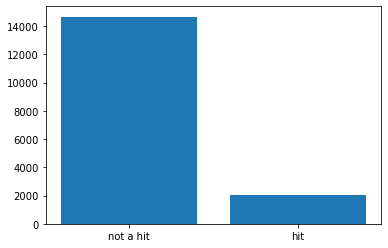

In [6]:
plt.bar(['not a hit', 'hit'], data['y'].value_counts())
plt.show()

Not surprisingly, only a small fraction of games can be considered "hits" under our metric. Next, we'll choose features that have predictive power for our target. We'll begin by plotting review scores versus global sales to check our hunch that such scores have an impact on sales. Logarithmic scale is used for clarity.

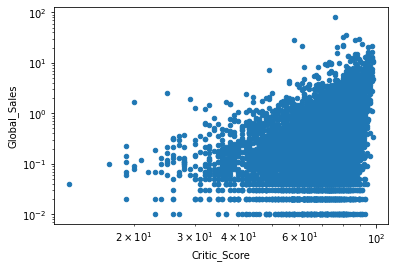

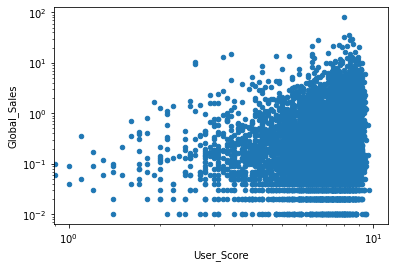

In [7]:
viz = data.filter(['User_Score','Critic_Score', 'Global_Sales'], axis=1)
viz['User_Score'] = pd.Series(viz['User_Score'].apply(pd.to_numeric, errors='coerce'))
viz['User_Score'] = viz['User_Score'].mask(np.isnan(viz["User_Score"]), viz['Critic_Score'] / 10.0)
viz.plot(kind='scatter', logx=True, logy=True, x='Critic_Score', y='Global_Sales')
viz.plot(kind='scatter', logx=True, logy=True, x='User_Score', y='Global_Sales')
plt.show()

Our intuition about the relationship between review scores and sales seems justified. We also note in passing that other relevant features can be extracted from the data set. For example, the ESRB rating has an impact since games with an "E" for everyone rating typically reach a wider audience than games with an age-restricted "M" for mature rating, though depending on another feature, the genre (such as shooter or action), M-rated games also can be huge hits. Our model hopefully will learn these relationships and others.  

Next, looking at the columns of features of this data set, we can identify several that should be excluded. For example, there are five columns that specify sales numbers: these numbers are directly related to the target we're trying to predict, so these columns should be dropped.  Other features may be irrelevant, such as the name of the game.

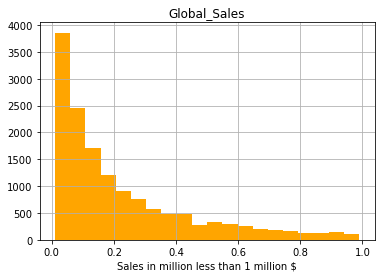

In [8]:
data[data["Global_Sales"]<1].hist(column="Global_Sales",bins = 20, color= 'orange' )
plt.xlabel("Sales in million less than 1 million $");

In [9]:
data = data.drop(['Name', 'Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Count', 'User_Count', 'Developer'], axis=1)

With the number of columns reduced, now is a good time to check how many columns are missing data:

In [10]:
data.isnull().sum()

Platform           0
Genre              2
Publisher         54
Critic_Score    8582
User_Score      6704
Rating          6769
y                  0
dtype: int64

As noted in Kaggle's overview of this data set, many review ratings are missing.  Unfortunately, since those are crucial features that we are relying on for our predictions, and there is no reliable way of imputing so many of them, we'll need to drop rows missing those features.

In [11]:
data = data.dropna()

Now we need to resolve a problem we see in the User_Score column: it contains some 'tbd' string values, so it obviously is not numeric. User_Score is more properly a numeric rather than categorical feature, so we'll need to convert it from string type to numeric, and temporarily fill in NaNs for the tbds. Next, we must decide what to do with these new NaNs in the User_Score column. We've already thrown out a large number of rows, so if we can salvage these rows, we should. As a first approximation, we'll take the value in the Critic_Score column and divide by 10 since the user scores tend to track the critic scores (though on a scale of 0 to 10 instead of 0 to 100).  

In [12]:
data['User_Score'] = data['User_Score'].apply(pd.to_numeric, errors='coerce')
data['User_Score'] = data['User_Score'].mask(np.isnan(data["User_Score"]), data['Critic_Score'] / 10.0)

Let's do some final preprocessing of the data, including converting the categorical features into numeric using the one-hot encoding method.

In [13]:
data['y'] = data['y'].apply(lambda y: 'yes' if y == True else 'no')
model_data = pd.get_dummies(data)

In [15]:
data

,Platform,Genre,Publisher,Critic_Score,User_Score,Rating,y
0,Wii,Sports,Nintendo,76.0,8.0,E,yes
2,Wii,Racing,Nintendo,82.0,8.3,E,yes
3,Wii,Sports,Nintendo,80.0,8.0,E,yes
6,DS,Platform,Nintendo,89.0,8.5,E,yes
7,Wii,Misc,Nintendo,58.0,6.6,E,yes
...,...,...,...,...,...,...,...
16699,GBA,Action,Titus,67.0,6.7,E,no
16700,PC,Shooter,Destineer,61.0,5.8,T,no
16701,GC,Puzzle,Ubisoft,53.0,5.3,E,no
16702,DS,Puzzle,Majesco Entertainment,48.0,4.8,E,no


To help prevent overfitting the model, we'll randomly split the data into three groups. Specifically, the model will be trained on 70% of the data. It will then be evaluated on 20% of the data to give us an estimate of the accuracy we hope to have on "new" data. As a final testing dataset, the remaining 10% will be held out until the end.

In [16]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   

XGBoost operates on data in the libSVM data format, with features and the target variable provided as separate arguments. To avoid any misalignment issues due to random reordering, this split is done after the previous split in the above cell. As a last step before training, we'll copy the resulting files to S3 as input for SageMaker's managed training.

In [ ]:
dump_svmlight_file(X=train_data.drop(['y_no', 'y_yes'], axis=1), y=train_data['y_yes'], f='train.libsvm')
dump_svmlight_file(X=validation_data.drop(['y_no', 'y_yes'], axis=1), y=validation_data['y_yes'], f='validation.libsvm')
dump_svmlight_file(X=test_data.drop(['y_no', 'y_yes'], axis=1), y=test_data['y_yes'], f='test.libsvm')

boto3.Session().resource('s3').Bucket(bucket).Object(prefix + '/train/train.libsvm').upload_file('train.libsvm')
boto3.Session().resource('s3').Bucket(bucket).Object(prefix + '/validation/validation.libsvm').upload_file('validation.libsvm')

In [ ]:
dump_svmlight_file(X=test2022_data.drop(['y_no', 'y_yes'], axis=1), y=test_data['y_yes'], f='test2022.libsvm')

---
## Training-Hosting

Next, we'll set up training jobs and deploy the resulting models.  For those steps, please return to the workshop lab guide after the previous code cell completes running, which may take a few minutes.  You'll return to this notebook for the final evaluation steps.

---

## Evaluation

Now that we have our hosted endpoint, we can generate predictions from it. More specifically, let's generate predictions from our test data set to understand how well our model generalizes to data it has not seen yet.  First, however, we need to bring in the name of the endpoint we created in the previous section of the module. If you followed the naming convention in the lab guide, the name is already filled in for the code cell below. Otherwise, replace the name with the one you chose.

In [17]:
endpoint_name = 'videogames-xgboost'

There are many ways to compare the performance of a machine learning model.  We'll start simply by comparing actual to predicted values of whether the game was a "hit" (`1`) or not (`0`).  Then we'll produce a  confusion matrix, which shows how many test data points were predicted by the model in each category versus how many test data points actually belonged in each category.

In [18]:
runtime = boto3.client('runtime.sagemaker')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [19]:
def do_predict(data, endpoint_name, content_type):
    payload = '\n'.join(data)
    response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=payload)
    result = response['Body'].read()
    result = result.decode("utf-8")
    result = result.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)], endpoint_name, content_type)
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items], endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

In [20]:
%%time
import json

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100, endpoint_name, 'text/x-libsvm')

print ('\nerror rate=%f' % ( sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))))

.........
error rate=0.135741
CPU times: user 33.8 ms, sys: 4 ms, total: 37.8 ms
Wall time: 169 ms


In [21]:
pd.crosstab(index=np.array(labels), columns=np.array(preds))

col_0,0,1
row_0,,
0,625,46
1,63,69


Of the 132 games in the test set that actually are "hits" by our metric, the model correctly identified 73, while the overall error rate is 13%.  The amount of false negatives versus true positives can be shifted substantially in favor of true positives by increasing the hyperparameter scale_pos_weight. Of course, this increase comes at the expense of reduced accuracy/increased error rate and more false positives. How to make this trade-off ultimately is a business decision based on the relative costs of false positives, false negatives, etc.

This concludes the notebook portion of this module. Please return to the workshop lab guide.